In [ ]:
import autograd.numpy as np
from autograd import grad
from autograd.numpy import log, sqrt, sin, cos, exp, pi, prod
from autograd.numpy.random import normal, uniform

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.pyplot import MultipleLocator
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
import imageio
import os
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/My Drive"

os.chdir(path)
os.listdir(path)

In [15]:
import numpy as np
np.random.seed(0)

In [16]:
def mixture(x):
    energy = ((x[0]**2 + x[1]**2)/10 - (cos(2.0*pi*x[0]) + cos(2.0*pi*x[1]))) / 0.5 # 2
    regularizer = ((x[0]**2 + x[1]**2) > 20) * ((x[0]**2 + x[1]**2) - 20)
    return energy + regularizer

def mixture_expand(x, y): return mixture([x, y])
def function_plot(x, y): return np.exp(-mixture([x, y]))

lower, upper = -2.5, 2.5
axis_x = np.linspace(lower, upper, 500)
axis_y = np.linspace(lower, upper, 500)
axis_X, axis_Y = np.meshgrid(axis_x, axis_y)

energy_grid = mixture_expand(axis_X, axis_Y)
prob_grid = function_plot(axis_X, axis_Y)

In [17]:
class Sampler:
    def __init__(self, f=None, dim=None, xinit=None,lr=[1e-3]*5, T=None, decay_lr=3e-3, init_var=25):
        self.N = len(xinit)
        self.f = f
        self.dim = dim
        self.lr = lr
        self.T = T
        self.unbiased_var = np.ones(self.N-1) * init_var
        self.decay_lr = decay_lr
        self.hat_var = np.ones(self.N-1) * init_var
        self.swap = [0] * (self.N - 1)

        # initialization
        self.x = np.array(xinit)

    def stochastic_grad(self, beta): return grad(self.f)(beta) + 0.25*normal(size=self.dim)

    def stochastic_f(self, beta): return self.f(beta.tolist()) + 0.25*normal(size=1)

    def resgld_step(self, iters):
        self.x = [self.x[i] - self.lr[i] * self.stochastic_grad(self.x[i]) 
        + sqrt(2. * self.lr[i] * self.T[i]) * normal(size=self.dim) for i in range(self.N)]
        self.swap = [0] * (self.N - 1)

        for j in range(self.N-1):
            if (iters+1) % 100 == 0:
                loss_stat = []
                for i in range(10):
                    loss_stat.append(self.stochastic_f(self.x[j]))

                step_size = min(self.decay_lr, 1./(iters**0.6+100))
                self.unbiased_var[j] = np.var(loss_stat)
                self.hat_var = (1-step_size) * self.hat_var + step_size * self.unbiased_var[j]
                
            integrand_corrected = min(1, exp((1/self.T[j+1] - 1/self.T[j]) * (self.stochastic_f(self.x[j+1])-self.stochastic_f(self.x[j]) - (1/self.T[j+1] - 1/self.T[j]) * self.hat_var[j]))[0])
            # print(integrand_corrected)
            
            if np.random.uniform(0,1,1) < integrand_corrected:
                self.x[j], self.x[j+1] = self.x[j+1], self.x[j]
                self.swap[j] = 1
            

## Call our sampler

In [18]:
sampler = Sampler(f=mixture, dim=2, xinit=[[0.,-1.],[0.,0.],[-1.,0.],[0.,1.],[1.,0.]], lr=[0.001,0.002, 0.003, 0.004, 0.005], T=[1,2,3,4,5], decay_lr = 3e-3)

In [8]:
my_images3 = []
warm_up = 1000
nepoch = 8e4
resgld_x = np.array(sampler.x)
swap_rec = []

PATH = 'anonymous/Contour-Stochastic-Gradient-Langevin-Dynamics/reSGLD_result/'
if not os.path.isdir(PATH):
    try:
        os.makedirs(PATH)
    except OSError as exc:  # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(PATH):
            pass
        else:
            raise

for iters in range(int(nepoch)):
    sampler.resgld_step(iters)
    if iters > warm_up:
        swap_rec.append(sampler.swap)
        if iters % 20 == 0:
            resgld_x = np.vstack((resgld_x, sampler.x[0]))
        if iters % 1000 == 0:
              print(iters)
              fig3 = plt.figure(figsize=(4, 4))
              plt.contour(axis_X, axis_Y, prob_grid, 10)
              plt.yticks([-4, -2, 0, 2, 4]) 
              plt.scatter(resgld_x[:,0], resgld_x[:,1], marker='.', s=3, color='k', label="Iteration="+str(iters)) 
              plt.legend(loc="upper left", prop={'size': 10})
              plt.xlim([lower, upper])
              plt.ylim([lower, upper])
              # plt.tight_layout()
              plt.show()
              fig3.canvas.draw()
              image3 = np.frombuffer(fig3.canvas.tostring_rgb(), dtype='uint8').reshape(fig3.canvas.get_width_height()[::-1] + (3,))
              my_images3.append(image3)
              plt.close('all')
          

imageio.mimsave(PATH+'Population_reSGLD_contour_'+str(sampler.lr)+"_"+str(sampler.T)+'.gif', my_images3, fps=50) 

import pickle
f = open(PATH + "swap_rec.txt", 'wb')
pickle.dump(swap_rec, f)
f.close() 
f = open(PATH + "samples.txt", 'wb')
pickle.dump(resgld_x, f)
f.close()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
fig = plt.figure(figsize=(7, 3.15))
plt.subplot(1, 2, 1).set_title('(a) Ground truth')
sns.heatmap(prob_grid, cmap="Blues", cbar=False, xticklabels=False, yticklabels=False).invert_yaxis()

warm_sample = 50
split_ = 1
plt.subplot(1, 2, 2).set_title('(b) population reSGLD')
ax = sns.kdeplot(resgld_x[:,0][::split_][warm_sample:], resgld_x[:,1][::split_][warm_sample:],  cmap="Blues", shade=True, thresh=0.05, bw=0.15)
ax.set_xlim(lower, upper)
ax.set_ylim(lower, upper)
plt.savefig(PATH+"population_reSGLD_"+str(sampler.lr)+"_"+str(sampler.T)+".png")
plt.close()

In [ ]:
fig = plt.figure(figsize=(3.15, 3.15))
PATH = 'anonymous/Contour-Stochastic-Gradient-Langevin-Dynamics/'
warm_sample = 0
split_ = 1
plt.subplot(1, 1, 1)
ax = sns.kdeplot(resgld_x[:,0][::split_][warm_sample:], resgld_x[:,1][::split_][warm_sample:],  cmap="Blues", shade=True, thresh=0.05, bw=0.15)
ax.set_xlim(lower, upper)
ax.set_ylim(lower, upper)
plt.savefig(PATH+"simulation_figures/population_reSGLD.png")
plt.close()

In [20]:
def KLdivergence(x, y):
    """Compute the Kullback-Leibler divergence between two multivariate samples.
    Parameters
    ----------
    x : 2D array (n,d)
      Samples from distribution P, which typically represents the true
      distribution.
    y : 2D array (m,d)
      Samples from distribution Q, which typically represents the approximate
      distribution.
    Returns
    -------
    out : float
      The estimated Kullback-Leibler divergence D(P||Q).
    References
    ----------
    Pérez-Cruz, F. Kullback-Leibler divergence estimation of
  continuous distributions IEEE International Symposium on Information
  Theory, 2008.
    """
    from scipy.spatial import cKDTree as KDTree

    # Check the dimensions are consistent
    x = np.atleast_2d(x)
    y = np.atleast_2d(y)

    n,d = x.shape
    m,dy = y.shape

    assert(d == dy)


    # Build a KD tree representation of the samples and find the nearest neighbour
    # of each point in x.
    xtree = KDTree(x)
    ytree = KDTree(y)

    # Get the first two nearest neighbours for x, since the closest one is the
    # sample itself.
    r = xtree.query(x, k=2, eps=.01, p=2)[0][:,1]
    s = ytree.query(x, k=1, eps=.01, p=2)[0]

    # There is a mistake in the paper. In Eq. 14, the right side misses a negative sign
    # on the first term of the right hand side.
    return -np.log(r/s).sum() * d / n + np.log(m / (n - 1.))

In [21]:
PATH = 'anonymous/Contour-Stochastic-Gradient-Langevin-Dynamics/'
import pickle
f = open(PATH + "simulation_figures/true_samples.txt", 'rb')
true_samples = pickle.load(f)
f.close()

In [11]:
resgld_kl = []
resgld_epochs = []
resgld_path = []
resgld_epoch_path = []  
for i in range(100, resgld_x.shape[0]):
    resgld_path.append(KLdivergence(true_samples, resgld_x[:i,:]))
resgld_kl.append(resgld_path)

In [ ]:
resgld_kl_array = np.array(resgld_kl)
resgld_epoch_array = np.array(resgld_epochs)
resgld_sd = np.array([np.std(resgld_kl_array[:,i]) for i in range(resgld_kl_array.shape[1])]) / np.sqrt(20)
resgld_mu = np.array([np.mean(resgld_kl_array[:,i]) for i in range(resgld_kl_array.shape[1])]) 
resgld_lower = resgld_mu - 1.96 * resgld_sd
resgld_upper = resgld_mu + 1.96 * resgld_sd

In [ ]:
x =  np.arange(7000, 4e5, 20)
re_x = np.arange(6600, 4e5, 100)
fig=plt.figure()
plt.plot(np.linspace(5100, 100000, 854), resgld_mu, label="re sgld")
plt.fill_between(np.linspace(5100, 100000, 854), resgld_lower, resgld_upper,
                 color = 'black', alpha = 0.15)


plt.legend()
plt.ylabel("KL divergence")
plt.xlabel("time steps")
plt.savefig(PATH + "reSGLD_result/kl.png")
plt.close()

# Plot the swap process

In [ ]:
import pickle
f = open(PATH + "reSGLD_result/old_result/swap_rec.txt", 'rb')
swap_rec = pickle.load(f)
swap_rec = np.array(swap_rec)

In [ ]:
swap_x, swap_y = [], []
noswap_x, noswap_y = [], []
route_x, route_y = [], []
left, right = 70000, 70050

# find route
pointer = 0


for i in range(left, right):
    tmp, flag = None, False
    for j in range(4):
        if j == pointer - 1:
            if pointer == 4 and swap_rec[i,j] == 0:
                route_x += [i, i+1, None]
                route_y += [pointer+1, pointer+1, None]
                continue
            if swap_rec[i,j] == 1:
                pointer -= 1
                route_x += [i, i+1, None]
                route_y += [pointer+2, pointer+1, None]
                continue
        elif j == pointer:
            if swap_rec[i,j] == 0:
                route_x += [i, i+1, None]
                route_y += [pointer+1, pointer+1, None]
            else:
                tmp = pointer + 1
                flag = True
        elif j > pointer and flag:
            if swap_rec[i,j] == 0:              
                break
            else:
                tmp += 1
            
    
    if tmp:
        route_x += [i, i+1, None]
        route_y += [pointer+1, tmp+1, None]
        pointer = tmp



for i in range(left, right):
    for j in range(4):
        if swap_rec[i,j] == 1:
            swap_x += [i, i+1, None, i, i+1, None]
            swap_y += [j+1, j+2, None, j+2, j+1, None]
            

        else:
            noswap_x += [i, i+1, None]
            noswap_y += [j+1, j+1, None]
            if j == 3:
                noswap_x += [i, i+1, None]
                noswap_y += [j+2, j+2, None]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


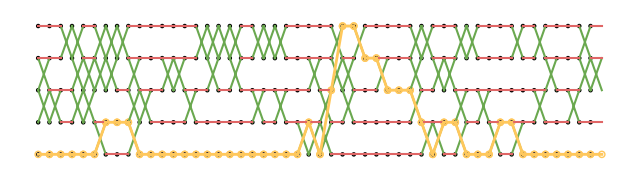

In [ ]:
nepoch=4e5
font1 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 11,
}

font2 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 11,
}

plt.style.use("default")
axis_x = list(range(int(nepoch)))
axis_X1, axis_Y1 = np.meshgrid(axis_x, axis_y)

fig = plt.figure(figsize=(8, 2))
ax=plt.gca()
ax.yaxis.set_major_locator(y_major_locator)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.ylim(0.7, 5.5)
plt.scatter(axis_X1[:,left:right], axis_Y1[:,left:right],s=5,marker='o',c='', edgecolors='black')
plt.plot(swap_x, swap_y,color='#6aa84f', alpha=1)
plt.plot(noswap_x, noswap_y,color='#e06666', alpha=1)
plt.scatter(route_x,route_y,s=20, marker='o',c='', edgecolors='#ffc85c')
plt.plot(route_x,route_y,linewidth=2,color='#ffc85c')
# plt.tick_params(labelsize=11)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,
    labelleft=False) # labels along the bottom edge are off
# labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]
# plt.subplots_adjust(left = 0,top=1)

fig.savefig(PATH + "simulation_figures/population_reSGLD_swap_"+str(sampler.lr)+"_"+str(sampler.T)+".png")

In [7]:
import pickle
PATH = "anonymous/Contour-Stochastic-Gradient-Langevin-Dynamics/SGLD_result/old_result/"
f = open(PATH + "population_SGLD_samples.txt",'rb')
samples = pickle.load(f)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


(-2.5, 2.5)

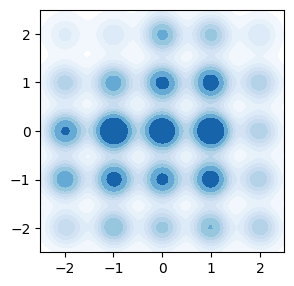

In [ ]:
plt.style.use('default')
fig = plt.figure(figsize=(3.15, 3.15))

warm_sample = 50
split_ = 1
plt.subplot(1, 1, 1)
ax = sns.kdeplot(samples[:,0][::split_][warm_sample:], samples[:,1][::split_][warm_sample:],  cmap="Blues", shade=True, thresh=0.05, bw=0.15)
ax.set_xlim(lower, upper)
ax.set_ylim(lower, upper)
# plt.savefig(PATH+"SGLD.png")
# plt.close()